In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

Dataset already downloaded.
Files in dataset folder: ['CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv']
Path to dataset files: /Users/jadlahrichi/.cache/kagglehub/datasets/agungpambudi/network-malware-detection-connection-analysis/versions/1


/var/folders/wx/l8wg57xn4zg_6jvfv7d2rly40000gn/T/ipykernel_29584/2986246779.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(0, inplace=True)  # Replace NaNs with 0


=== DATA BALANCE ANALYSIS ===
Class distribution: Counter({0: 8262389, 1: 2185398})
Class 0 (Benign): 8262389 (79.08%)
Class 1 (Malicious): 2185398 (20.92%)
Imbalance ratio: 3.78:1
Dataset is imbalanced

=== APPLYING DATA BALANCING ===
Balancing method used: SMOTE
Balanced class distribution: Counter({1: 8262389, 0: 8262389})
New dataset size: 16524778 (original: 10447787)


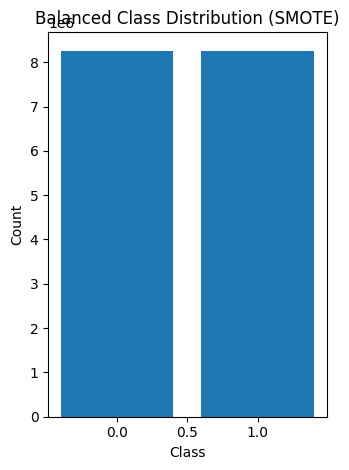

In [4]:
import os

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    IMBALANCED_LEARN_AVAILABLE = True
except ImportError:
    print("Warning: imbalanced-learn not available. Install with: pip install imbalanced-learn")
    IMBALANCED_LEARN_AVAILABLE = False

# Define the path where files will be extracted
dataset_path = "/Users/jadlahrichi/.cache/kagglehub/datasets/agungpambudi/network-malware-detection-connection-analysis/versions/1"

# Download selected version only if not already downloaded
if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    path = kagglehub.dataset_download("agungpambudi/network-malware-detection-connection-analysis/versions/1")
else:
    print("Dataset already downloaded.")
    path = dataset_path

# List files in that directory
files = os.listdir(dataset_path)
print("Files in dataset folder:", files)

# Assuming there's one large CSV (you can adjust this if needed)
csv_file = next((f for f in files if f.endswith(".csv")), None)

# Read the CSV (pipe-separated, as in CTU datasets)
data = pd.read_csv(os.path.join(dataset_path, csv_file), sep='|', low_memory=False)

print("Path to dataset files:", path)
drop_cols = ['uid', 'history', 'tunnel_parents', 'detailed-label', 'local_resp', 'local_orig', 'missed_bytes']
data.drop(columns=drop_cols, inplace=True, errors='ignore')

data.dropna(subset=['label', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes'], inplace=True)

for col in ['duration', 'orig_bytes', 'resp_bytes']:
    data[col] = data[col].replace('-', np.nan)  # Replace '-' with NaN
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric
    data[col].fillna(0, inplace=True)  # Replace NaNs with 0

data['proto'] = data['proto'].astype('category').cat.codes
data['service'] = data['service'].astype('category').cat.codes

data['label'] = data['label'].apply(lambda x: 0 if x == 'Benign' else 1)

features = ['proto', 'service', 'duration', 'orig_bytes', 'resp_bytes']
X = data[features]
y = data['label']

print("=== DATA BALANCE ANALYSIS ===")
class_distribution = Counter(y)
print(f"Class distribution: {class_distribution}")
print(f"Class 0 (Benign): {class_distribution[0]} ({class_distribution[0]/len(y)*100:.2f}%)")
print(f"Class 1 (Malicious): {class_distribution[1]} ({class_distribution[1]/len(y)*100:.2f}%)")

# Calculate imbalance ratio
minority_class = min(class_distribution.values())
majority_class = max(class_distribution.values())
imbalance_ratio = majority_class / minority_class
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

is_imbalanced = imbalance_ratio > 2.0
print(f"Dataset is {'imbalanced' if is_imbalanced else 'balanced'}")

X_balanced, y_balanced = X.copy(), y.copy()

if is_imbalanced and IMBALANCED_LEARN_AVAILABLE:
    print("\n=== APPLYING DATA BALANCING ===")
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("Balancing method used: SMOTE")
    balanced_distribution = Counter(y_balanced)
    print(f"Balanced class distribution: {balanced_distribution}")
    print(f"New dataset size: {len(y_balanced)} (original: {len(y)})")

    plt.subplot(1, 2, 2)
    plt.bar(balanced_distribution.keys(), balanced_distribution.values())
    plt.title('Balanced Class Distribution (SMOTE)')
    plt.xlabel('Class')
    plt.ylabel('Count')

elif is_imbalanced and not IMBALANCED_LEARN_AVAILABLE:
    print("\n=== MANUAL BALANCING (Simple Random Oversampling) ===")
    # Simple manual balancing if imbalanced-learn is not available
    minority_class_label = 0 if class_distribution[0] < class_distribution[1] else 1
    majority_class_label = 1 - minority_class_label

    # Get indices for each class
    minority_indices = y[y == minority_class_label].index
    majority_indices = y[y == majority_class_label].index

    # Oversample minority class
    n_samples_needed = len(majority_indices) - len(minority_indices)
    oversampled_indices = np.random.choice(minority_indices, n_samples_needed, replace=True)

    # Combine all indices
    balanced_indices = np.concatenate([majority_indices, minority_indices, oversampled_indices])

    # Create balanced dataset
    X_balanced = X.iloc[balanced_indices].reset_index(drop=True)
    y_balanced = y.iloc[balanced_indices].reset_index(drop=True)

    print("Balancing method used: Random Oversampling")
    balanced_distribution = Counter(y_balanced)
    print(f"Balanced class distribution: {balanced_distribution}")

plt.tight_layout()
plt.show()


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)
print("Data split into training and testing sets.")


Data split into training and testing sets.



---
### Using GPU with XGBoost

To leverage the GPU, we can use the `XGBoost` library, which supports Apple Silicon GPUs. First, we need to install it.


In [4]:

%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



Now, let's train an XGBoost classifier using the GPU.


In [5]:

import xgboost as xgb

# Check if MPS is available
if xgb.config.get_config().get("USE_MPS", False):
    print("MPS is available, using GPU.")
    device = "mps"
else:
    print("MPS not available, using CPU.")
    device = "cpu"

# Create an XGBoost classifier
# The `device` parameter is set to "mps" to enable GPU acceleration on Apple Silicon.
# All other parameters are set to be similar to the RandomForestClassifier for comparison.
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    device=device,  # Use 'mps' for Apple Silicon GPU
    eval_metric='logloss',
    use_label_encoder=False
)


MPS not available, using CPU.


In [6]:
print("\n=== XGBoost CROSS-VALIDATION ANALYSIS (GPU) ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_clf, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== XGBoost CROSS-VALIDATION ANALYSIS (GPU) ===
[21:06:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:06:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:07:14] WARNING: /Users/runner/work/xgboost/

In [7]:
print("\n=== XGBoost FINAL MODEL TRAINING (GPU) ===")
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print("Test Set Results (XGBoost):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")


=== XGBoost FINAL MODEL TRAINING (GPU) ===
[21:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Test Set Results (XGBoost):
Test Set Results (XGBoos

In [8]:
print("\n=== DETAILED EVALUATION (XGBoost) ===")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost):")
print(cm_xgb)


=== DETAILED EVALUATION (XGBoost) ===
Confusion Matrix (XGBoost):
[[2473348    5369]
 [ 351977 2126740]]
Confusion Matrix (XGBoost):
[[2473348    5369]
 [ 351977 2126740]]


In [9]:
import joblib
import json

# --- EXPORTING MODEL AND PREPROCESSING OBJECTS ---

# 1. Save the trained XGBoost model
model_filename = 'flowguard_xgboost_model.pkl'
joblib.dump(xgb_clf, model_filename)
print(f"Model saved to {model_filename}")

# 2. Save the feature list and categorical mappings
# Re-create categorical types to save the learned categories
proto_dtype = pd.CategoricalDtype(categories=data['proto'].astype('category').cat.categories)
service_dtype = pd.CategoricalDtype(categories=data['service'].astype('category').cat.categories)

preprocessing_data = {
    'features': features,
    'proto_categories': list(proto_dtype.categories),
    'service_categories': list(service_dtype.categories)
}

preprocessing_filename = 'flowguard_preprocessing.json'
with open(preprocessing_filename, 'w') as f:
    json.dump(preprocessing_data, f)
print(f"Preprocessing data saved to {preprocessing_filename}")


Model saved to flowguard_xgboost_model.pkl
Preprocessing data saved to flowguard_preprocessing.json
